In [1047]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
from sklearn.preprocessing import StandardScaler
## 분류 문제를 위한 pycaret 라이브러리 (pycaret.classification)
from pycaret.classification import * 
from time import time
import matplotlib
import matplotlib.pyplot as plt
#import plotly.express as px

data_path = './competition_data/'

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [1048]:
train = pd.read_csv(data_path + 'train.csv') 
test =  pd.read_csv(data_path + 'test.csv')

### 데이터 전처리(EDA)를 해봅시다.

In [1049]:
test_cols = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10',
             'Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19','Q20',
             'Q21','Q22', 'Q23','Q24','Q25','Q26']

## 응시 시간 문항에 대한 Column
time_cols = ['introelapse', 'testelapse', 'surveyelapse']

## TIPI 문항에 대한 Column
tipi_cols = ['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8',
             'TIPI9','TIPI10']

vcl_exist = ['VCL1','VCL2','VCL3','VCL4','VCL5','VCL7','VCL8','VCL10','VCL11','VCL13','VCL14','VCL15','VCL16']
vcl_no_exist = ['VCL6','VCL9','VCL12']
## VCL 문항에 대한 Column
vcl_cols = vcl_exist + vcl_no_exist

## 설문문항에 대한 Column
survy_cols = ['education','urban','gender','engnat','age','hand','religion',
              'orientation','voted','married','familysize','ASD']

cntry_cols = ['country']

## 이산형 - 명목형 변수
norminal_cols = vcl_cols + ['country', 'urban', 'gender', 'engnat','hand', 'religion', 'orientation', 'voted','married','ASD']

## 설명이 없는 변수
##  => test 문항 (Q21~Q26, Q6, Q14, Q18)
##  => education, urban, gender, engnat, age, hand, religion, orientation, voted, married, familysize, ASD

+ 26개 문항에 대한 테스트 응답 점수를 총합하여 추가해보겠습니다.

In [1050]:
def calcTest(dframe):
    tmp_frame=dframe.copy()
    tmp_frame['test_score'] = tmp_frame[test_cols].sum(axis=1)/len(test_cols)
    return tmp_frame

In [1051]:
pre_train = calcTest(train.copy())
pre_test = calcTest(test.copy())

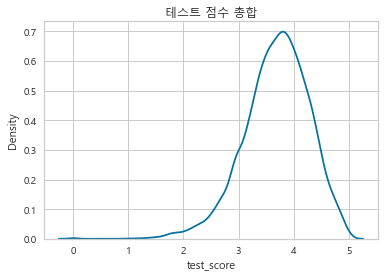

In [1052]:
sns.kdeplot(pre_train['test_score'])     ## 응답자 별 테스트 점수 총합을 확률 분포로 그리기
plt.title("테스트 점수 총합")
plt.show()

+ TIPI 점수를 계산해 추가해보겠습니다.

In [1053]:
def calcTIPI(dframe):
    tp_enc = dframe.copy()
    tp_enc['tp_extra'] = (dframe['TIPI1'] + (8-dframe['TIPI6']))/2 ## 외향성 
    tp_enc['tp_agree'] = (dframe['TIPI7'] + (8-dframe['TIPI2']))/2 ## 친화성
    tp_enc['tp_consc'] = (dframe['TIPI3'] + (8-dframe['TIPI8']))/2 ## 성실성
    tp_enc['tp_emoti'] = (dframe['TIPI9'] + (8-dframe['TIPI4']))/2 ## 정서적 안정성
    tp_enc['tp_opens'] = (dframe['TIPI5'] + (8-dframe['TIPI10']))/2 ## 경험에 대한 개방성
    tp_enc['tp_means'] =  dframe[tipi_cols].mean(axis=1)
    
    return tp_enc

In [1054]:
pre_train = calcTIPI(pre_train) ## TIPI 계산

pre_test = calcTIPI(pre_test)

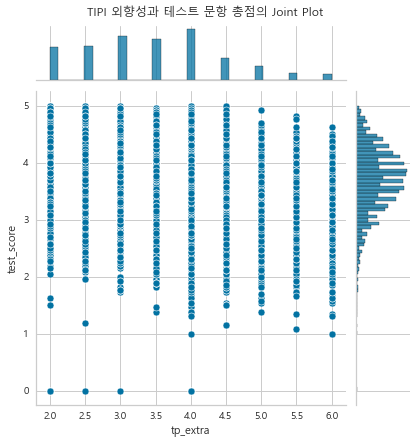

In [1055]:
sns.jointplot(x="tp_extra", y="test_score", data=pre_train)
plt.suptitle("TIPI 외향성과 테스트 문항 총점의 Joint Plot", y=1.02)
plt.show()

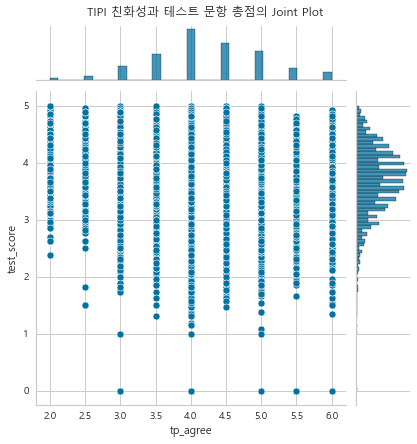

In [1056]:
sns.jointplot(x="tp_agree", y="test_score", data=pre_train)
plt.suptitle("TIPI 친화성과 테스트 문항 총점의 Joint Plot", y=1.02)
plt.show()

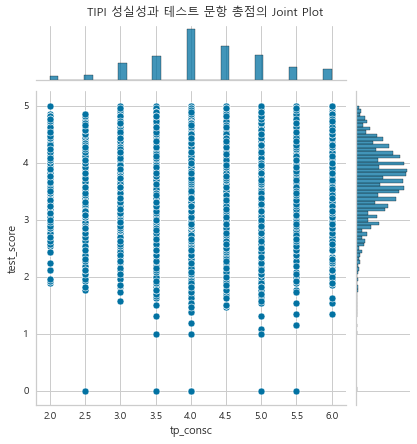

In [1057]:
sns.jointplot(x="tp_consc", y="test_score", data=pre_train)
plt.suptitle("TIPI 성실성과 테스트 문항 총점의 Joint Plot", y=1.02)
plt.show()

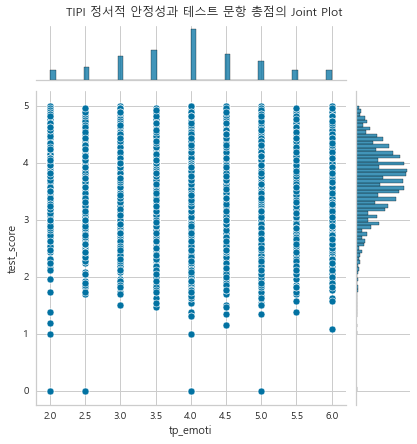

In [1058]:
sns.jointplot(x="tp_emoti", y="test_score", data=pre_train)
plt.suptitle("TIPI 정서적 안정성과 테스트 문항 총점의 Joint Plot", y=1.02)
plt.show()

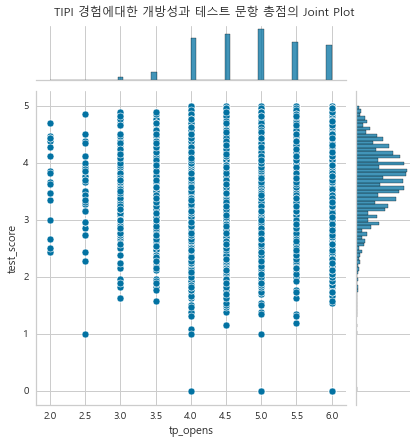

In [1059]:
sns.jointplot(x="tp_opens", y="test_score", data=pre_train)
plt.suptitle("TIPI 경험에대한 개방성과 테스트 문항 총점의 Joint Plot", y=1.02)
plt.show()

+ 상대적으로, 외향성 점수, 친화성 점수가 낮은 사람들이 테스트 문항 총점의 높은 곳에 몰려 있음
+ 반면에, 정서적 안정성, 성실성, 경험에 대한 개방성은 테스트 문항의 총점 평균과 눈에띄는 관계를 찾아보기 힘들었음. 따라서, 이 셋은 Drop

+ 존재하지 않는 단어들 중 안다고 체크한 단어들의 개수, 존재하는 단어들 중 안다고 체크한 단어들의 개수를 계산해보겠습니다.

In [1060]:
def word_count(dframe):
    tmp_frame = dframe.copy()
    tmp_frame['exist_know'] = tmp_frame[vcl_exist].sum(axis=1)
    tmp_frame['no_exist_know'] = tmp_frame[vcl_no_exist].sum(axis=1)
    tmp_frame['total_wr_know'] = tmp_frame['exist_know'] + tmp_frame['no_exist_know']
    return tmp_frame

In [1061]:
pre_train = word_count(pre_train)
pre_test = word_count(pre_test)

+ 신뢰성 없는 답변을 제거합니다.
  + 모든 테스트 문항에 같은 답으로 응답했으면서, 테스트 응시시간이 짧은 사람 (문항단 최소 약 4초라 설정), 즉, 104초보다 응답시간이 짧은 사람
  + 16 개의 단어를 모두 안다고 체크했으면서, 설문문항 응시시간이 짧은 사람
  + 모든 TIPI 문항에 같은 답으로 응답했으면서, 설문문항 응시시간이 짧은 사람

In [1062]:
'''
def delUnrelRow(dframe):
    tmp_frame=dframe.copy()
    testelpse_th = len(test_cols)*4  
    srvyelpse_th = len(vcl_cols + survy_cols+tipi_cols) * 4
    
    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 5) & (tmp_frame['testelapse'] <testelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 4) & (tmp_frame['testelapse'] <testelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 3) & (tmp_frame['testelapse'] <testelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 2) & (tmp_frame['testelapse'] <testelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 1) & (tmp_frame['testelapse'] <testelpse_th)].index)
    
    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['total_wr_know'] == 16) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)
    
    tmp_frame = tmp_frame.drop(tmp_frame.loc[  (tmp_frame['tp_means'] == 5) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[  (tmp_frame['tp_means'] == 4) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[  (tmp_frame['tp_means'] == 3) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[  (tmp_frame['tp_means'] == 2) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)
    tmp_frame = tmp_frame.drop(tmp_frame.loc[  (tmp_frame['tp_means'] == 1) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)
    
    return tmp_frame


## 16 
'''

"\ndef delUnrelRow(dframe):\n    tmp_frame=dframe.copy()\n    testelpse_th = len(test_cols)*4  \n    srvyelpse_th = len(vcl_cols + survy_cols+tipi_cols) * 4\n    \n    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 5) & (tmp_frame['testelapse'] <testelpse_th)].index)\n    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 4) & (tmp_frame['testelapse'] <testelpse_th)].index)\n    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 3) & (tmp_frame['testelapse'] <testelpse_th)].index)\n    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 2) & (tmp_frame['testelapse'] <testelpse_th)].index)\n    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['test_score'] == 1) & (tmp_frame['testelapse'] <testelpse_th)].index)\n    \n    tmp_frame = tmp_frame.drop(tmp_frame.loc[(tmp_frame['total_wr_know'] == 16) & (tmp_frame['surveyelapse'] <srvyelpse_th)].index)\n    \n    tmp_frame = tmp_frame.drop(tmp_frame.loc[  (tmp_fram

In [1063]:
# pre_train = delUnreRoew(pre_train)

+ age 변수의 경우, 300 이상의 값들로 인해 분포 파악이 어려우므로, 300 이상의 값들을 평균치로 대체합니다,

In [1064]:
def delAge300(r):
    if r.age >= 300:
        return pre_train['age'].mean()
    return r.age


pre_train['age'] = pre_train.apply(lambda r: delAge300(r), axis=1)
pre_test['age'] = pre_test.apply(lambda r: delAge300(r), axis=1) 

+ family 변수의 경우, 20 이상의 값들로 인해 분포 파악이 어려우므로, 20 이상의 값들을 평균치로 대체합니다,

In [1065]:
def delfam20(r):
    if r.familysize >= 20:
        return pre_train['familysize'].mean()
    return r.familysize


pre_train['familysize'] = pre_train.apply(lambda r: delfam20(r), axis=1)
pre_test['familysize'] = pre_test.apply(lambda r: delfam20(r), axis=1) 

+ 결측치를 대체해야합니다. 결측치를 가진 Row 가 2177 개 입니다. 너무 많으니(전체데이터 셋의 15%), 이들을 삭제할 수는 없습니다.
  + 이산형 - 순위형 변수들, 즉, 테스트 문항/TIPI 문항은,
  + 연속형 - 수치형 변수 (age, familysize)

In [1066]:
def subNANMean(dframe):
    nan_cols = ['tp_extra', 'tp_agree' , 'tp_consc' , 'tp_emoti', 'tp_opens', 'test_score'] + ['testelapse','surveyelapse']
    tmp_frame = dframe.copy()
    tmp_frame[nan_cols] =  tmp_frame[nan_cols].fillna(round(tmp_frame[nan_cols].mean()))
    return tmp_frame
    
def subNANMode(dframe):
    nan_cols = ['age','familysize', 'hand', 'gender', 'ASD', 'country']
    tmp_frame = dframe.copy()
    tmp_frame[nan_cols] =  tmp_frame[nan_cols].fillna(tmp_frame[nan_cols].mode().iloc[0])
    return tmp_frame

In [1067]:
pre_train = subNANMean(pre_train)
pre_test = subNANMean(pre_test)

pre_train = subNANMode(pre_train)
pre_test = subNANMode(pre_test)

+ country 속성의 경우, training 셋 에서는, 국가별 nerdiness 1, 0 비율에 따라 4개의 그룹으로 분류하고, test 셋에서의 경우, training 셋에서 보지못한 데이터들이 존재하므로, 이들을 별도의 다른 그룹으로 관리

In [1068]:
def ratio_table(cross_tab):
    return cross_tab.div(cross_tab.sum(axis=1),axis='index')
def groupCntryCol(dframe):
    tmp_country = train[['country','nerdiness']].dropna()
    native_country_table=tmp_country['country'].value_counts()
    country_count = tmp_country['country'].unique().shape[0]
    
    country_crosstab=pd.crosstab(tmp_country['country'],tmp_country['nerdiness'])
    country_crossgtab_res=ss.chi2_contingency(country_crosstab)
    
    country_ratio=ratio_table(country_crosstab)
    country_ratio=country_ratio.sort_values(by=0)
    
    prob_dict=dict(country_ratio[1])
    
    cntry_group1=[]
    cntry_group2=[]
    cntry_group3=[]
    cntry_group4=[]

    for country in tmp_country['country'].unique():
        country_data=tmp_country[tmp_country['country']==country]['nerdiness']
        probs=sum(country_data)/country_data.count()
        if probs <= 1 and probs >=0.6:
            cntry_group1.append(country)
        elif probs >=0.4 and probs <0.6:
            cntry_group2.append(country)
        elif probs >= 0.2 and probs < 0.4:
            cntry_group3.append(country)
        else:
            cntry_group4.append(country)
    #print(country,probs)
    return (cntry_group1, cntry_group2, cntry_group3, cntry_group4)


    

def cat_country(dframe,group):
    tmp_frame = dframe.copy()    
    tmp_frame['country']=tmp_frame['country'].replace(group[0],0)
    tmp_frame['country']=tmp_frame['country'].replace(group[1],1)
    tmp_frame['country']=tmp_frame['country'].replace(group[2],2)
    tmp_frame['country']=tmp_frame['country'].replace(group[3],3)
    tmp_frame['country']=tmp_frame['country'].replace(group[4],4)
    
    return tmp_frame

In [1069]:
cntry_groups =  list(groupCntryCol(pre_train))
cntry_groups_1d =  cntry_groups[0] + cntry_groups[1] + cntry_groups[2] + cntry_groups[3] 

new_cntry = list(set(pre_test['country'].unique()).difference(set(cntry_groups_1d)))
cntry_groups.append(new_cntry)
pre_train =  cat_country(pre_train, cntry_groups)
pre_test =  cat_country(pre_test, cntry_groups)

+ 그외 설명없는 변수들을 어떻게 처리할 것인가?
  + ASD-테스트 총합 점수 간의 joint plot 그려볼 경우, ASD 1.0 값을 가진 사람이, 높은 테스트 점수에 많이 몰려있었다. ASD Column 은 유지한다 (원-핫 인코딩)
  + hand-테스트 총합 점수 간의 join plot 그려볼 경우, hand 값이 3에 가까운 사람들일 수록, 고득점의 테스트 응답 점수대에 몰려있었다. hand Column 은 유지한다. (원-핫 인코딩)
  + gender-테스트 총합 점수 간의 join plot 그려볼 경우, gender 값이 3에 가까운 사람들일 수록, 고득점의 테스트 응답 점수대에 몰려있었다. gender Column 은 유지한다. (원-핫 인코딩)
  + familysize-테스트 총합 점수 간의 join plot 그려볼 경우, familysize 값이 큰 사람들일 수록, 고득점의 테스트 응답 점수대에 몰려있었다. familysize Column 은 유지한다. (최댓값이 딱히 정해져있지 않는 것으로 보아, 수치형으로 보이고, 드문드문 있는 것으로 보아 이산형으로 판단이 가능할 듯)
  + age-테스트 총합 점수 간의 join plot 그려볼 경우, age 값이 큰 사람들일 수록, 고득점의 테스트 응답 점수대에 몰려있었다. familysize Column 은 유지한다. (최댓값이 딱히 정해져있지 않는 것으로 보아, 수치형으로 보이고, 드문드문 있는 것으로 보아 이산형으로 판단이 가능할 듯)

In [1070]:
def one_hot_encoding(dframe):
    tmp_frame = dframe.copy()
    categorical_cols = ['country','ASD','gender','hand']
    
    for col in categorical_cols:
        col_ohe = pd.get_dummies(tmp_frame[col], prefix=col)
        tmp_frame = pd.concat((tmp_frame, col_ohe), axis=1).drop(col, axis=1)
    return tmp_frame

In [1071]:
pre_train = one_hot_encoding(pre_train)
pre_test = one_hot_encoding(pre_test)

pre_train['country_4'] = 0
cols = pre_train.columns.tolist()
cols = cols[:80] + ['country_4'] + cols[80:-1]

pre_train = pre_train[cols]

+ 학습에 필요없다고 판단되는 Column 삭제
  + + intro 를 읽는데 소요한 시간을 의미하는 introelapse 의 경우도, testelapse 나 surveyelapse에 비해, 테스트의 신뢰도에 큰 영향을 끼치지 못한다고 판단하여 Drop

In [1073]:
droplist = tipi_cols + test_cols + ['tp_consc', 'tp_emoti', 'tp_opens', 'introelapse', 'education', 'urban', 
                                    'engnat', 'religion','orientation','voted','married', 'tp_means','total_wr_know','index'] + vcl_cols 

In [1074]:
pre_train =pre_train.drop(droplist,axis=1)
pre_test = pre_test.drop(droplist,axis=1)

+ testelapse, surveyelapse 의 경우, 편차가 크므로 정규화

In [1075]:
def stdize_cols(dframe):
    tmp_frame =dframe.copy()
    col_stdize = ['testelapse', 'surveyelapse']
    scaler = StandardScaler()
    numeric_df = pd.DataFrame(scaler.fit_transform(tmp_frame[col_stdize]),columns=col_stdize,index=tmp_frame.index)
    X_train_new = tmp_frame.drop(columns=col_stdize)
    train_final_ohe_stdize =pd.concat([numeric_df,X_train_new],axis=1)
    return train_final_ohe_stdize

In [1076]:
pre_train =stdize_cols(pre_train)
pre_test = stdize_cols(pre_test)

+ 모델 성능 비교를 위한 데이터셋을 로드해봅시다.

In [1077]:
## Dataset 에 대한 Engineering 
## 주의!!, pycaret 은 데이터 셋 준비 -> 준비된 데이터 셋 기반하여 실험(experiment) 진행 -> Model 성능 비교 ... 의 파이프라인을 따르기에,
##        반드시, 데이터셋을 로드/준비 하는 setup 함수가 pycaret 의 그 어떤 다른 함수들보다도 먼저 호출되어야 함. 

## pycaret.classification.setup
## => data : 사용 Data
## => target : 타겟 변수의 이름
## => train_size : 전체 데이터 셋들 중 train 데이터셋의 비율, 기본값 0.7

clf = setup(data = pre_train, target='nerdiness', silent=True)

#test_cols = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10',
#             'Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19','Q20',
#             'Q21','Q22', 'Q23','Q24','Q25','Q26']

## 응시 시간 문항에 대한 Column
#time_cols = ['introelapse', 'testelapse', 'surveyelapse']

## TIPI 문항에 대한 Column
#tipi_cols = ['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8',
#             'TIPI9','TIPI10']

#vcl_exist = ['VCL1','VCL2','VCL3','VCL4','VCL5','VCL7','VCL8','VCL10','VCL11','VCL13','VCL14','VCL15','VCL16']
#vcl_no_exist = ['VCL6','VCL9','VCL12']
## VCL 문항에 대한 Column
#vcl_cols = vcl_exist + vcl_no_exist

## 설문문항에 대한 Column
#survy_cols = ['education','urban','gender','engnat','age','hand','religion',
#              'orientation','voted','married','familysize','ASD']

#cntry_cols = ['country']

## 이산형 - 명목형 변수
#norminal_cols = vcl_cols + ['country', 'urban', 'gender', 'engnat','hand', 'religion', 'orientation', 'voted','married','ASD']

## 설명이 없는 변수
##  => test 문항 (Q21~Q26, Q6, Q14, Q18)
##  => education, urban, gender, engnat, age, hand, religion, orientation, voted, married, familysize, ASD
'''
ignore_features=['index','introelapse']

clf = setup(data=train, 
            target='nerdiness', 
            ignore_features=ignore_features,           # 분석/학습에 고려하지 않을 feature(컬럼) 제거
           # categorical_features=categorical_features, # 범주형 컬럼 지정
            #numeric_features=numeric_features,         # 수치형 컬럼 지정
            normalize=True,                            # 정규화 적용
            normalize_method='zscore',                 # 정규화 방식 지정
            imputation_type='iterative',               # 결측치를 lightgbm으로 예측하여 채움
            iterative_imputation_iters=10,             # imputation iteration 지정
            categorical_iterative_imputer='lightgbm',
            # bin_numeric_features=['age', 'trestbps', 'chol','thalach', 'oldpeak'], # numeric 컬럼에 대하여 binning
            polynomial_features=True,
            silent=True,
            ) 
            '''

,Description,Value
0,session_id,4808
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 42)"
5,Missing Values,False
6,Numeric Features,22
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


"\nignore_features=['index','introelapse']\n\nclf = setup(data=train, \n            target='nerdiness', \n            ignore_features=ignore_features,           # 분석/학습에 고려하지 않을 feature(컬럼) 제거\n           # categorical_features=categorical_features, # 범주형 컬럼 지정\n            #numeric_features=numeric_features,         # 수치형 컬럼 지정\n            normalize=True,                            # 정규화 적용\n            normalize_method='zscore',                 # 정규화 방식 지정\n            imputation_type='iterative',               # 결측치를 lightgbm으로 예측하여 채움\n            iterative_imputation_iters=10,             # imputation iteration 지정\n            categorical_iterative_imputer='lightgbm',\n            # bin_numeric_features=['age', 'trestbps', 'chol','thalach', 'oldpeak'], # numeric 컬럼에 대하여 binning\n            polynomial_features=True,\n            silent=True,\n            ) \n            "

+ 준비된 데이터셋을 기반으로하여, 모델의 성능을 평가해봅시다.

In [1078]:
## 
## pycaret.classification.compare_models
## => fold : K-겹 교차 검증 시, 폴드 개수 K 
## => round : 성능에 대한 점수를 소수 몇번째 자리까지 표기할 것인지를 결정
## => sort : 성능 평가 척도
## => n_select : 성능 평가 점수 상위 몇개의 모델을 가져올까? 결정

cell_start_time = time()
top5_models = compare_models(fold = 6, round = 5, sort='AUC', n_select=5)
cell_end_time = time()

print("CELL RUN TIME : ", cell_end_time - cell_start_time)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.75502,0.83338,0.82623,0.75610,0.78960,0.49783,0.50067,0.96500
et,Extra Trees Classifier,0.73302,0.81757,0.80020,0.74086,0.76936,0.45358,0.45551,1.07833
lightgbm,Light Gradient Boosting Machine,0.72378,0.78992,0.80568,0.72739,0.76447,0.43267,0.43609,0.17667
xgboost,Extreme Gradient Boosting,0.72626,0.78911,0.78993,0.73712,0.76254,0.44034,0.44194,1.37333
gbc,Gradient Boosting Classifier,0.71454,0.77980,0.80448,0.71699,0.75818,0.41265,0.41685,1.11833
lr,Logistic Regression,0.71273,0.77626,0.79232,0.71968,0.75419,0.41053,0.41344,1.10667
lda,Linear Discriminant Analysis,0.71388,0.77589,0.80619,0.71560,0.75814,0.41092,0.41545,0.12667
ada,Ada Boost Classifier,0.71045,0.77315,0.80243,0.71322,0.75513,0.40394,0.40826,0.35167
dt,Decision Tree Classifier,0.68407,0.68027,0.71392,0.71702,0.71544,0.36035,0.36039,0.11167
nb,Naive Bayes,0.61520,0.65102,0.81013,0.61931,0.70064,0.18767,0.20240,0.04667


CELL RUN TIME :  65.18245196342468


+ rf(Random Forest Classifier) 와 et(Extra Trees Classifier) 의 AUC 성능(교차 검증)이 0.841 로 제일 높았음. 그외에도, xgboost (Extreme Gradient Boosting), lightgbm (Light Gradient Boosting Machine), gbc (Gradient Boosting Classifier) 들의 성능들이 바로 후순위에 위치

In [1079]:
top5_models         ## 성능 상위 5개 모델들에 대한 정보

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=False, random_state=4808, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                 

In [1080]:
total_models = []
models()  

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### 상위 5개의 모델들을 생성해봅시다.
+ Gradient Boosting Classifier

In [1081]:
## pycaret.classification.create_model
## => estimator : 생성할 Model 의 이름
## => cross_validation :
## => 
## => fold 
## => round

cell_start_time = time()
model_gbc = create_model(estimator = 'gbc', fold = 5, cross_validation=True)
total_models.append(model_gbc)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7029,0.7614,0.7920,0.7083,0.7478,0.3890,0.3926
1,0.7071,0.7729,0.8031,0.7090,0.7531,0.3967,0.4013
2,0.7329,0.7840,0.8348,0.7260,0.7766,0.4484,0.4552
3,0.7195,0.7905,0.8033,0.7234,0.7612,0.4236,0.4270
4,0.7208,0.7879,0.8142,0.7205,0.7645,0.4249,0.4297
Mean,0.7166,0.7793,0.8095,0.7174,0.7606,0.4165,0.4212
Std,0.0107,0.0108,0.0145,0.0074,0.0099,0.0214,0.0223


CELL RUN TIME :  9.44829249382019


+ Extreme Gradient Boosting 모델을 생성해봅시다.

In [1082]:
cell_start_time = time()
model_xgboost = create_model('xgboost', fold = 5, cross_validation=True)
total_models.append(model_xgboost)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)
model_xgboost

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7100,0.7697,0.7714,0.7249,0.7474,0.4078,0.4089
1,0.7214,0.7869,0.7902,0.7308,0.7594,0.4299,0.4317
2,0.7176,0.7831,0.7997,0.7224,0.7590,0.4202,0.4233
3,0.7329,0.7910,0.7930,0.7440,0.7677,0.4542,0.4554
4,0.7346,0.7928,0.7997,0.7430,0.7703,0.4572,0.4589
Mean,0.7233,0.7847,0.7908,0.7330,0.7608,0.4338,0.4356
Std,0.0093,0.0082,0.0104,0.0090,0.0080,0.0192,0.0191


CELL RUN TIME :  10.227128505706787


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=4808, reg_alpha=0, ...)

+ Light Gradient Boosting Machine 모델을 생성해봅시다.

In [1083]:
cell_start_time = time()
model_lightgbm = create_model('lightgbm', fold = 5, cross_validation=True)
total_models.append(model_lightgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)
model_lightgbm

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7095,0.7751,0.7928,0.7156,0.7522,0.4035,0.4066
1,0.7233,0.7860,0.8039,0.7273,0.7637,0.4320,0.4352
2,0.7271,0.7871,0.8185,0.7259,0.7694,0.4382,0.4430
3,0.7248,0.7909,0.7998,0.7310,0.7639,0.4356,0.4381
4,0.7261,0.7965,0.8065,0.7297,0.7662,0.4375,0.4407
Mean,0.7222,0.7871,0.8043,0.7259,0.7631,0.4294,0.4327
Std,0.0064,0.0071,0.0085,0.0055,0.0058,0.0131,0.0133


CELL RUN TIME :  2.003706932067871


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4808, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

+ Extra Trees Classifier 모델을 생성해봅시다.

In [1084]:
cell_start_time = time()
model_et = create_model('et', fold = 5, cross_validation=True)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)
model_et

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7171,0.7982,0.7911,0.7253,0.7568,0.4204,0.4227
1,0.7262,0.8104,0.7877,0.7378,0.7619,0.4406,0.4419
2,0.7281,0.8127,0.8116,0.7298,0.7685,0.4413,0.4450
3,0.7195,0.8003,0.7921,0.7280,0.7587,0.4253,0.4274
4,0.7432,0.8294,0.8108,0.7486,0.7785,0.4742,0.4764
Mean,0.7268,0.8102,0.7987,0.7339,0.7649,0.4404,0.4427
Std,0.0091,0.0111,0.0104,0.0085,0.0079,0.0188,0.0188


CELL RUN TIME :  7.036494016647339


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=4808, verbose=0,
                     warm_start=False)

+ Random Forest Classifier 모델을 생성해봅시다.

In [1085]:
cell_start_time = time()
model_rf = create_model('rf', fold = 5, cross_validation=True)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)
model_rf

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7395,0.8091,0.8091,0.7447,0.7755,0.4665,0.4688
1,0.7471,0.8291,0.8176,0.7502,0.7825,0.4819,0.4845
2,0.7486,0.8279,0.8348,0.7443,0.7869,0.4827,0.4875
3,0.7481,0.8288,0.8084,0.7560,0.7813,0.4851,0.4866
4,0.7656,0.8410,0.8365,0.7645,0.7989,0.5194,0.5224
Mean,0.7498,0.8272,0.8213,0.7519,0.7850,0.4871,0.4900
Std,0.0086,0.0102,0.0122,0.0076,0.0078,0.0174,0.0176


CELL RUN TIME :  6.184216499328613


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=4808, verbose=0,
                       warm_start=False)

In [1086]:
total_models

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=4808, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
    

#### 모델의 하이퍼파라미터들을 튜닝해봅시다.</b>

+ Gradient Boosting Classifier 모델을 튜닝해봅시다.

In [1087]:
## pycaret.classification.tune_model
## => estimator
## => fold 
## => round
## => optimize : 파라미터 튜닝 과정에서 따라갈 평가 척도
## => choose_better : True로 설정하면, 성능이 높아지지 않을 경우 tuning 전의 모델을 반환


model_gbc = tune_model(estimator=model_gbc, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6943,0.7577,0.7731,0.7055,0.7377,0.3731,0.3754
1,0.7148,0.7798,0.7997,0.7190,0.7572,0.4139,0.4173
2,0.7324,0.7848,0.8202,0.7313,0.7732,0.4494,0.4539
3,0.7210,0.7950,0.7930,0.7293,0.7598,0.4283,0.4304
4,0.7365,0.7965,0.8219,0.7356,0.7764,0.4582,0.4624
Mean,0.7198,0.7828,0.8016,0.7242,0.7609,0.4246,0.4279
Std,0.0149,0.0140,0.0182,0.0108,0.0137,0.0301,0.0308


+ Extreme Gradient Boosting 모델을 튜닝해봅시다.

In [1088]:
model_xgboost = tune_model(model_xgboost, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6981,0.7824,0.9170,0.6660,0.7716,0.3578,0.3997
1,0.7067,0.7963,0.9212,0.6725,0.7775,0.3766,0.4188
2,0.7029,0.7957,0.9272,0.6677,0.7763,0.3670,0.4134
3,0.7081,0.8007,0.9162,0.6753,0.7775,0.3803,0.4194
4,0.7146,0.8028,0.9298,0.6775,0.7838,0.3931,0.4379
Mean,0.7061,0.7956,0.9223,0.6718,0.7773,0.3750,0.4179
Std,0.0055,0.0071,0.0054,0.0044,0.0039,0.0120,0.0123


+ Extra Trees Classifier 모델을 튜닝해봅시다.

In [1089]:
model_et = tune_model(model_et, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6819,0.7520,0.6764,0.7315,0.7028,0.3618,0.3630
1,0.6895,0.7647,0.7140,0.7240,0.7190,0.3722,0.3722
2,0.7105,0.7702,0.7440,0.7377,0.7408,0.4129,0.4129
3,0.7057,0.7861,0.7271,0.7398,0.7334,0.4051,0.4051
4,0.7137,0.7841,0.7389,0.7446,0.7417,0.4205,0.4205
Mean,0.7003,0.7714,0.7201,0.7355,0.7276,0.3945,0.3948
Std,0.0124,0.0126,0.0242,0.0071,0.0148,0.0232,0.0229


+ Random Forest Classifier 모델을 튜닝해봅시다.

In [1090]:
model_rf = tune_model(model_rf, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6919,0.7539,0.7252,0.7221,0.7236,0.3756,0.3756
1,0.6948,0.7729,0.7337,0.7220,0.7278,0.3804,0.3805
2,0.7110,0.7713,0.7671,0.7279,0.7470,0.4105,0.4113
3,0.7152,0.7853,0.7263,0.7533,0.7395,0.4257,0.4260
4,0.7261,0.7908,0.7842,0.7393,0.7611,0.4407,0.4418
Mean,0.7078,0.7748,0.7473,0.7329,0.7398,0.4066,0.4070
Std,0.0128,0.0128,0.0240,0.0120,0.0135,0.0253,0.0256


+ Light Gradient Boosting Machine 모델을 튜닝해봅시다.

In [1091]:
model_lightgbm = tune_model(model_lightgbm, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6995,0.7696,0.7748,0.7109,0.7415,0.3844,0.3864
1,0.7200,0.7792,0.7945,0.7273,0.7594,0.4261,0.4285
2,0.7129,0.7749,0.7988,0.7171,0.7558,0.4099,0.4134
3,0.7224,0.7892,0.7921,0.7314,0.7606,0.4315,0.4335
4,0.7361,0.7883,0.8116,0.7395,0.7739,0.4586,0.4615
Mean,0.7182,0.7802,0.7944,0.7252,0.7582,0.4221,0.4246
Std,0.0120,0.0076,0.0119,0.0102,0.0104,0.0245,0.0247


In [1092]:
tuned_models = [model_gbc, model_xgboost, model_lightgbm, model_et, model_rf]

#### Model 별 성능을 Plot 해 봅시다.

+ Gradient Boosting Classifier 모델의 AUC 를 Plot

+ Light Gradient Boosting Machine 모델의 AUC 를 Plot

+ Extreme Gradient Boosting 모델의 AUC 를 Plot

+ Extra Trees Classifier 모델의 AUC 를 Plot

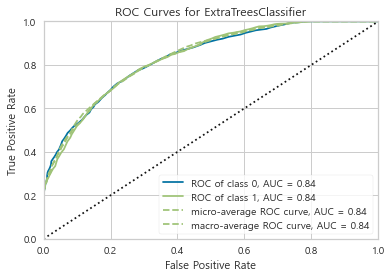

In [960]:
plot_model(model_et, plot='auc')

+ Random Forest Classifier 모델의 AUC 를 Plo

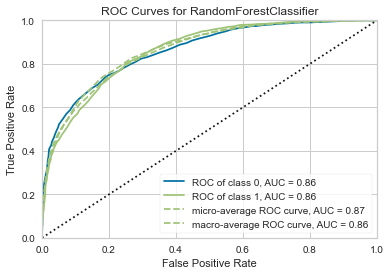

In [99]:
plot_model(model_rf, plot='auc')

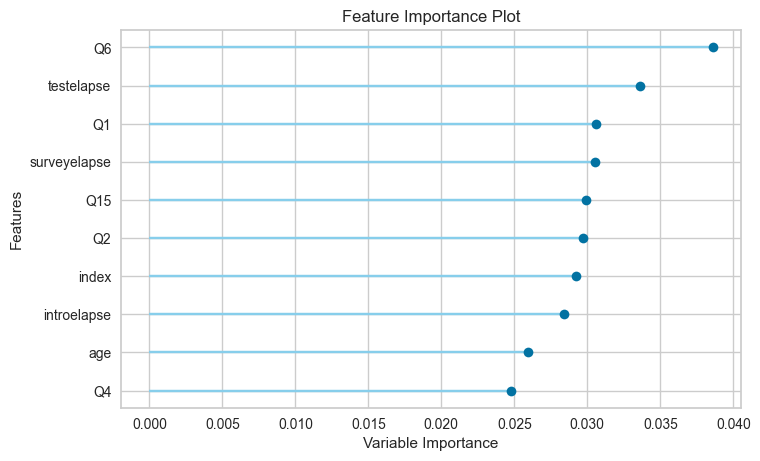

In [100]:
plot_model(model_rf, plot='feature')

#### 전체 데이터 셋의 30%를 교차 데이터 셋으로 이용하여, 교차검증을 실시합시다. 

In [1093]:
## pycaret.classification.predict_models
## => estimator
## => data : 별도의 검증 데이터 셋을 사용할 경우, 직접 명시, Dataframe 형태이며, 
## => probability_threshold : 

for model in tuned_models:
    display(predict_model(model))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7250,0.7991,0.8245,0.7158,0.7663,0.4361,0.4426


,testelapse,surveyelapse,age,familysize,test_score,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,...,exist_know_8,exist_know_9,no_exist_know_0,no_exist_know_1,no_exist_know_2,no_exist_know_3,country_4_0,nerdiness,Label,Score
0,0.008814,-0.014709,18.0,2.0,3.500000,4.0,3.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.6034
1,-0.032183,-0.014961,54.0,2.0,3.807692,2.5,3.5,4.0,5.5,5.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.6410
2,-0.032770,-0.014536,18.0,2.0,3.961539,4.0,4.5,3.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.7445
3,-0.028894,-0.014642,31.0,4.0,3.269231,3.5,3.5,4.0,3.5,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.7975
4,-0.034180,-0.014883,26.0,1.0,3.115385,3.5,5.0,4.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.5996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,-0.031831,-0.014418,33.0,3.0,3.884615,3.5,3.0,5.0,4.5,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.6358
4497,-0.036529,-0.014676,18.0,3.0,3.576923,4.5,4.5,5.0,3.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0.5097
4498,-0.032653,-0.014721,19.0,2.0,3.692308,4.0,4.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0.5636
4499,-0.030891,-0.014385,19.0,2.0,3.653846,3.5,4.5,5.0,5.5,4.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.6118


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7063,0.8198,0.9431,0.6627,0.7784,0.3801,0.4357


,testelapse,surveyelapse,age,familysize,test_score,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,...,exist_know_8,exist_know_9,no_exist_know_0,no_exist_know_1,no_exist_know_2,no_exist_know_3,country_4_0,nerdiness,Label,Score
0,0.008814,-0.014709,18.0,2.0,3.500000,4.0,3.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0.7608
1,-0.032183,-0.014961,54.0,2.0,3.807692,2.5,3.5,4.0,5.5,5.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.9211
2,-0.032770,-0.014536,18.0,2.0,3.961539,4.0,4.5,3.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.9133
3,-0.028894,-0.014642,31.0,4.0,3.269231,3.5,3.5,4.0,3.5,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.6589
4,-0.034180,-0.014883,26.0,1.0,3.115385,3.5,5.0,4.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.5991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,-0.031831,-0.014418,33.0,3.0,3.884615,3.5,3.0,5.0,4.5,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.9195
4497,-0.036529,-0.014676,18.0,3.0,3.576923,4.5,4.5,5.0,3.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.7244
4498,-0.032653,-0.014721,19.0,2.0,3.692308,4.0,4.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0.8685
4499,-0.030891,-0.014385,19.0,2.0,3.653846,3.5,4.5,5.0,5.5,4.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.9532


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7303,0.8037,0.8233,0.7224,0.7696,0.4478,0.4533


,testelapse,surveyelapse,age,familysize,test_score,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,...,exist_know_8,exist_know_9,no_exist_know_0,no_exist_know_1,no_exist_know_2,no_exist_know_3,country_4_0,nerdiness,Label,Score
0,0.008814,-0.014709,18.0,2.0,3.500000,4.0,3.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0.5220
1,-0.032183,-0.014961,54.0,2.0,3.807692,2.5,3.5,4.0,5.5,5.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.6911
2,-0.032770,-0.014536,18.0,2.0,3.961539,4.0,4.5,3.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.7747
3,-0.028894,-0.014642,31.0,4.0,3.269231,3.5,3.5,4.0,3.5,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.7902
4,-0.034180,-0.014883,26.0,1.0,3.115385,3.5,5.0,4.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.6549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,-0.031831,-0.014418,33.0,3.0,3.884615,3.5,3.0,5.0,4.5,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.7398
4497,-0.036529,-0.014676,18.0,3.0,3.576923,4.5,4.5,5.0,3.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.6148
4498,-0.032653,-0.014721,19.0,2.0,3.692308,4.0,4.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0.5610
4499,-0.030891,-0.014385,19.0,2.0,3.653846,3.5,4.5,5.0,5.5,4.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.6668


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7552,0.8369,0.8184,0.7547,0.7853,0.5016,0.5038


,testelapse,surveyelapse,age,familysize,test_score,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,...,exist_know_8,exist_know_9,no_exist_know_0,no_exist_know_1,no_exist_know_2,no_exist_know_3,country_4_0,nerdiness,Label,Score
0,0.008814,-0.014709,18.0,2.0,3.500000,4.0,3.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0.57
1,-0.032183,-0.014961,54.0,2.0,3.807692,2.5,3.5,4.0,5.5,5.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,1.00
2,-0.032770,-0.014536,18.0,2.0,3.961539,4.0,4.5,3.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.77
3,-0.028894,-0.014642,31.0,4.0,3.269231,3.5,3.5,4.0,3.5,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1.00
4,-0.034180,-0.014883,26.0,1.0,3.115385,3.5,5.0,4.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,-0.031831,-0.014418,33.0,3.0,3.884615,3.5,3.0,5.0,4.5,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.62
4497,-0.036529,-0.014676,18.0,3.0,3.576923,4.5,4.5,5.0,3.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0.66
4498,-0.032653,-0.014721,19.0,2.0,3.692308,4.0,4.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0.64
4499,-0.030891,-0.014385,19.0,2.0,3.653846,3.5,4.5,5.0,5.5,4.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.58


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7707,0.8525,0.8444,0.7621,0.8012,0.5321,0.5360


,testelapse,surveyelapse,age,familysize,test_score,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,...,exist_know_8,exist_know_9,no_exist_know_0,no_exist_know_1,no_exist_know_2,no_exist_know_3,country_4_0,nerdiness,Label,Score
0,0.008814,-0.014709,18.0,2.0,3.500000,4.0,3.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0.51
1,-0.032183,-0.014961,54.0,2.0,3.807692,2.5,3.5,4.0,5.5,5.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.88
2,-0.032770,-0.014536,18.0,2.0,3.961539,4.0,4.5,3.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.79
3,-0.028894,-0.014642,31.0,4.0,3.269231,3.5,3.5,4.0,3.5,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.91
4,-0.034180,-0.014883,26.0,1.0,3.115385,3.5,5.0,4.0,3.5,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,-0.031831,-0.014418,33.0,3.0,3.884615,3.5,3.0,5.0,4.5,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.64
4497,-0.036529,-0.014676,18.0,3.0,3.576923,4.5,4.5,5.0,3.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0.61
4498,-0.032653,-0.014721,19.0,2.0,3.692308,4.0,4.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0.56
4499,-0.030891,-0.014385,19.0,2.0,3.653846,3.5,4.5,5.0,5.5,4.5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.50


+ Extra Tree Classifier 의 AUC Score 가 0.8760 으로 가장 높았음. Random Forest Model 의 경우, 0.8718 로, 거의 비슷하게 높았음. 이 2개의 모델을 중심적으로 사용

#### 생성 모델을 최종적으로 사용할 모델로 변환
+ 앞 단계에서 결정된 모델(알고리즘)과, 최상의 하이퍼파라미터 조합으로 학습을 진행

In [1094]:
## pycaret.classification.finalize_model
## => estimator
## => train_size = 1 (setup 에서 설정한 Dataset 전체를, Model 학습에 사용)

final_model = finalize_model(model_rf)

#### 테스트 데이터 셋을 기반으로 타겟값 예츳

In [1095]:
prediction = predict_model(final_model, data = pre_test)

In [1096]:
prediction

,testelapse,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,...,ASD_1.0,ASD_2.0,gender_1.0,gender_2.0,gender_3.0,hand_1.0,hand_2.0,hand_3.0,Label,Score
0,-0.029198,-0.018728,1,1,1,1,1,1,1,1,...,0,1,0,1,0,1,0,0,0,0.61
1,-0.029923,-0.019033,1,1,1,1,1,0,0,1,...,0,1,1,0,0,1,0,0,1,0.60
2,-0.031997,-0.019156,1,1,0,1,1,0,0,1,...,0,1,0,1,0,1,0,0,1,0.75
3,-0.024947,-0.018605,1,1,1,1,1,1,1,0,...,0,1,1,0,0,1,0,0,1,0.60
4,-0.024118,-0.018349,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,-0.020282,-0.018637,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,1,0.67
35448,-0.026917,-0.019452,1,0,0,1,1,0,0,1,...,0,1,0,0,1,0,0,1,1,0.65
35449,-0.028472,-0.019156,1,1,1,1,1,0,0,0,...,0,1,1,0,0,1,0,0,1,0.74
35450,-0.035004,-0.019864,1,1,0,1,1,1,0,1,...,0,1,1,0,0,1,0,0,1,0.54


#### 전처리 방식에 따른 특성중요도 차이 관찰

+ RandomForest + 전처리 x

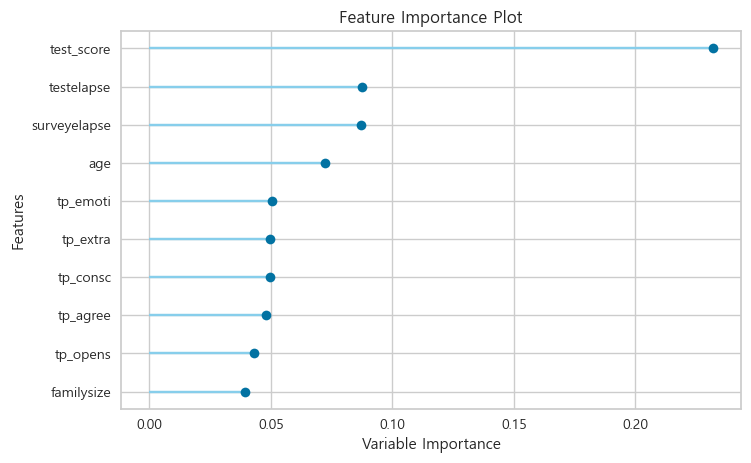

In [1097]:
plot_model(final_model, plot='feature')

#### 완성된 Model pkl 파일로 저장

In [109]:
PKL_NAME = 'Classification_DACON_drop_nan'
save_model(final_model,PKL_NAME)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='nerdiness',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nod

#### Model pkl 파일 불러오기

In [110]:
saved_final_model = load_model(PKL_NAME)

Transformation Pipeline and Model Successfully Loaded


#### 예측된 타겟값을 csv 파일로 저장

In [1098]:
sample_submission = pd.read_csv(data_path+'sample_submission.csv')
sample_submission['nerdiness'] = round(prediction['Label'])
display(sample_submission.head())
sample_submission.to_csv('Classification_DACON_last3' + '.csv',index=False)

,index,nerdiness
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
